## wgMLST for mbovis

* http://www3.ridom.de/seqsphere/cgmlst/
* https://www.cgmlst.org/ncs/schema/741110/
* https://jcm.asm.org/content/52/7/2479
* https://www.biorxiv.org/content/10.1101/172858v1.full
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3980634/

## steps

* get MLST gene list
* assembly
* annotate
* assign allele numbers?

In [327]:
import sys,os,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 150)
import pylab as plt
import seaborn as sns
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from io import StringIO
import snipgenie as snpg
import pathogenie as pg

In [361]:
vcf_file='/storage/btbgenie/all_ireland_results/filtered.vcf.gz'

In [ ]:
path = '/storage/btbgenie/mbovis_ireland/Wicklow/Fastqs_07-01-18/'
files = glob.glob(os.path.join(path, '*.gz'))
samp = snpg.app.get_samples(files)
pairs = pd.pivot_table(samp,index=['sample'],columns=['pair'],values='filename',aggfunc='first').reset_index()
print (pairs)

## create reference proteins for MLST

In [131]:
prots = pg.tools.genbank_to_dataframe('Mbovis-AF212297.2.gb',cds=True)
prots = prots.fillna('')
prots = prots.dropna(subset=['locus_tag'])
ref_proteins = 'Mbovis_AF212297_proteins.fa'
#get prokka type header for using in annotation
prots['header'] = prots.apply(lambda x: '~~~'.join([x.locus_tag,x.gene,x['product'],'none']),1)
pg.tools.dataframe_to_fasta(prots,idkey='header',outfile=ref_proteins)
print (len(prots))

3994


In [159]:
def get_nucleotide_sequences(gb_file,out_file,idkey='locus_tag'):
    """protein nucleotide seqs from genbank"""
    
    recs = SeqIO.to_dict(SeqIO.parse(gb_file,'genbank'))
    chrom = list(recs.keys())[0]
    refrec = recs[chrom]
    result = []
    for f in refrec.features[1:]:
        q=f.qualifiers
        if f.type != 'CDS':
            continue
        seq = refrec.seq[f.location.start:f.location.end]
        try:
            new = SeqRecord(seq,id=q[idkey][0])    
        except:
            #print (q)
            pass
        result.append(new)
    SeqIO.write(result,out_file,format='fasta')
    return

get_nucleotide_sequences('Mbovis-AF212297.2.gb','Mbovis_AF212297_nuc.fa')

## assembly

In [ ]:
def spades(file1, file2, out, threads=4):
    """Run spades"""
    
    cmd = 'spades -t %s --pe1-1 %s --pe1-2 %s --careful -o %s' %(threads,file1,file2,outpath)
    print (cmd)
    if not os.path.exists(out): 
        subprocess.check_output(cmd, shell=True)
    return 

path = '/storage/btbgenie/assembly/'

for i,r in pairs[:1].iterrows():
    print (r[1])
    out = os.path.join(path,r['sample'])
    spades(r[1], r[2], out,threads=10)

## get consensus sequence from alignment instead of assembly

In [254]:
def get_consensus(vcf_file, sample, out_file):
    """Get consensus sequence from vcf"""
      
    cmd='bcftools index %s' %vcf_file
    #subprocess.check_output(cmd, shell=True)
    cmd='cat {r} | bcftools consensus -s {s} {v} > {o}'.format(r=snpg.app.mbovis_genome,v=vcf_file,s=sample,o=out_file)
    #print (cmd)
    subprocess.check_output(cmd, shell=True)
    return

get_consensus(vcf_file, '1034','consensus.fa')

## annotate


In [ ]:
#seqfile='/storage/btbgenie/assembly/17/scaffolds.fasta'
seqfile='consensus.fa'
featdf,recs = pg.run_annotation(seqfile,
                                threads=10, kingdom='bacteria', trusted=ref_proteins)
fastafile='/storage/btbgenie/annotation/17.fa'
#df = pg.tools.records_to_dataframe(recs)
#df['protein_id'] = df.protein_id.fillna(df.locus_tag)
#pg.tools.dataframe_to_fasta(df,idkey='protein_id',outfile=fastafile)

#write out nucl sequences
SeqIO.write(recs,'temp.gb','genbank')
get_nucleotide_sequences('temp.gb',fastafile,idkey='protein_id')

# initialise MLST table from reference genome

## filter only Mb proteins in scheme

In [368]:
mlst=pd.read_csv('mlst_scheme.csv')
mlst=mlst[mlst['Ridom Usage']=='MLST+']
targets=list(mlst.Target)

In [369]:
mbmap=pd.read_csv('final_mbovis_mapping.csv')
mbmap = mbmap[mbmap.Rv_tag.isin(targets)]
mb_tags = list(mbmap.Mb_tag)
prots = prots[prots.locus_tag.isin(mb_tags)]
nucseqs = pg.tools.fasta_to_dataframe('Mbovis_AF212297_nuc.fa')
nucseqs = nucseqs[nucseqs.name.isin(mb_tags)]

In [370]:
cols = ['name','allele','sequence']
ref = nucseqs.copy()
ref['allele'] = 1
ref=ref.rename(columns={'translation':'sequence'})
ref[cols].to_csv('mlst_db.csv.gz',index=False,compression='gzip')
print (len(ref))

3185


In [335]:
#check a sample against the allele table
fastafile='/storage/btbgenie/annotation/1034.fa'

def find_alleles(fastafile):
    """Find allele by simple matches to the reference table of known sequences.
    Returns:
        dataframe with allele number for each gene
        dataframe with new alleles to add to db
    """
    
    db = pd.read_csv('mlst_db.csv.gz')
    names = ref.name.unique()
    df = pg.tools.fasta_to_dataframe(fastafile)
    result=[]
    new=[]
    for name in names:
        #print (name)
        s = db[db.name==name]
        gene = df[df.name==name]
        if len(gene)==0:
            #print (name)
            continue
        target = gene.iloc[0].sequence
        found = s[s.sequence==target]        
        #print (found)
        if len(found)>0:
            found = found.iloc[0]
            result.append((name,found.allele))
        else:
            #assign new allele
            newallele = s.allele.max()+1
            result.append((name,newallele))
            new.append([name,newallele,target])
    prof = pd.DataFrame(result,columns=['name','allele'])
    prof['allele'] = prof.allele.astype(int)
    new = pd.DataFrame(new,columns=['name','allele','sequence'])
    return prof, new
    
def update_mlst_db(new):
    """Update the database of MLST profiles"""
    
    db = pd.read_csv('mlst_db.csv.gz')
    db = pd.concat([db,new])
    db.to_csv('mlst_db.csv.gz', index=False, compression='gzip')
    print ('added %s new alleles' %len(new))
    return

res,new = find_alleles(fastafile)
print (res)
update_mlst_db(new)

         name  allele
0     Mb0014c       1
1     Mb0015c       1
2     Mb0016c       1
3     Mb0017c       1
4     Mb0018c       2
...       ...     ...
3095  Mb3936c       1
3096  Mb3937c       1
3097   Mb3938       2
3098   Mb3939       1
3099   Mb3940       1

[3100 rows x 2 columns]
added 0 new alleles


In [363]:
def type_sample(sample, vcf_file, path, threads=4, overwrite=False):
    """Type a single sample using wgMLST.
    Args:
        sample: sample name, must be present in vcf file
        vcf_file: source vcf 
        path: output folder for annotations
    Returns:
        dataframe of MLST profile
    """
    
    seqfile = 'consensus.fa'
    fastafile = os.path.join(path,'%s.fa' %sample)
    #use consensus for now    
    get_consensus(vcf_file, sample, seqfile)
    if overwrite == True or not os.path.exists(fastafile):
        #annotate
        featdf,recs = pg.run_annotation(seqfile,
                                    threads=threads, kingdom='bacteria', trusted=ref_proteins)
        #get nucl sequences from annotation    
        SeqIO.write(recs,'temp.gb','genbank')
        get_nucleotide_sequences('temp.gb',fastafile,idkey='protein_id')    
    #find alleles
    res,new = find_alleles(fastafile)
    #print (res)
    #update db
    update_mlst_db(new)
    return res

res = type_sample('26-MBovis', vcf_file, '/storage/btbgenie/annotation/')

added 0 new alleles


In [248]:
def get_samples_vcf(vcf_file):
    cmd = 'bcftools query -l %s' %vcf_file
    tmp = subprocess.check_output(cmd, shell=True)
    return tmp.decode().split('\n')
    
samplenames = get_samples_vcf(vcf_file)

In [ ]:
profs = {}
for s in samplenames[:40]:
    print (s)
    if s == '182-MBovis':
        continue
    profile = type_sample(s, vcf_file, '/storage/btbgenie/annotation/', threads=12)
    profs[s] = get_profile_string(profile)

## find distances between profiles

In [340]:
def get_profile_string(df):
    return ''.join(df.allele.astype(str))


In [341]:
def diff_profiles(s1, s2):
    return sum(1 for a, b in zip(list(s1), list(s2)) if a != b)


In [354]:
def dist_matrix(profiles):
    """Distance matrix of a set of profiles"""
    
    dist=[]
    for s in profiles:
        x=profs[s]
        row=[]
        for s in profs:
            d = diff_profiles(x,profs[s])
            row.append(d)
        dist.append(row)
    D = pd.DataFrame(dist,columns=profs.keys(),index=profs.keys())
    return D

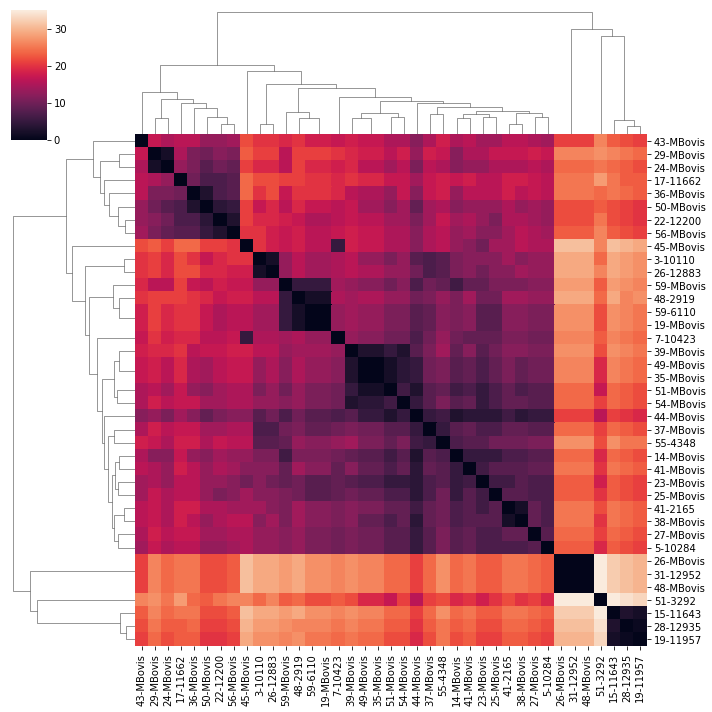

In [389]:
D = dist_matrix(profs)
sns.clustermap(D,xticklabels=True,yticklabels=True)

In [387]:
def tree_from_distance_matrix(X):
    """Distance matrix to phylo tree"""

    from Bio import Phylo
    from Bio.Phylo.TreeConstruction import DistanceMatrix,DistanceTreeConstructor
    from Bio.Cluster import distancematrix

    names = list(X.index)
    if type(X) is pd.DataFrame:
        X = X.values
    mat = distancematrix(X)
    new=[]
    for i in mat:
        new.append(np.insert(i, 0, 0).tolist())

    dm = DistanceMatrix(names,new)
    constructor = DistanceTreeConstructor()
    tree = constructor.nj(dm)
    #Phylo.draw_ascii(tree,file=open('temp.txt','w'))
    return tree

tree = tree_from_distance_matrix(D)
treefile = 'test.newick'
Phylo.write(tree,treefile,format='newick')

1

In [ ]:
Phylo.draw_ascii(tree)

In [ ]:
import toytree
meta = pd.read_csv('/storage/btbgenie/mbovis_ireland/all_ireland_samples.csv')
#mapping = dict(zip(meta['sample'],meta.clade))

tre = toytree.tree(treefile)
canvas,t,r=tre.draw(layout='r')